# INWAZJA ZOMBIE! - RAPORT KOŃCOWY

## Wstęp

W trakcie ostatnich kilkudziesięciu lat teksty kultury traktujące o końcu świata stały się niezwykle popularne w środkach masowego przekazu na całym świecie. Jedną z form przedstawiania apokaliptycznych wizji jest napad zombie - żywych trupów, wskrzeszonych do życia dzięki nadprzyrodzonym mocom złowieszczego czarodzieja. Trudno sobie wyobrazić jak przedstawiałoby się zachowanie społeczeństwa w obliczu nagłego pojawienia się takiego zagrożenia w rzeczywistości. Wszechobecna panika, brak możliwości przygotowania oraz brak wytłumaczenia zjawiska z pewnością byłyby czynnikami utrudniającymi obronę. W związku z różnymi możliwościami zachowań populacji ludzi, autorzy artykułu `When zombies attack!: Mathematical modelling of an outbreak of zombie infection.` przygotowali kilka różnorodnych modeli matematycznych przedstawiających możliwy rozwój ataku w czasie. W trakcie poszukiwań właściwych sposobów obrony przed śmiercionośnym zagrożeniem, sprawdzono jak inwazja może przebiegać w przypadku gdy zarażenie następuje natychmiastowo lub po pewnym czasie, uwzględniono zastosowanie działania prewencyjnego, jakim byłaby izolacja części osobników zombie od reszty społeczeństwa oraz zbadano na ile pomocne okazałoby się wynalezienie leku przywracające zombie do życia. W poniższym raporcie znajdują się dokładne wizualizacje oraz analizy wymienionych modeli.

### Zombie oraz Brad Pitt (po lewej) w filmie World War Z

![](WWZ-image.png)

Zaczniemy od załadowania odpowiednich bibliotek. Warto wyróżnić pakiety `scipy` oraz `numpy` do przeprowadzania obliczeń, bibliotekę `matplotlib` wykorzystywaną do wizualizacji, `ipywidgets` odpowiedzialny za interakcje oraz wreszcie `chaospy`, który dodaje do powstałych wykresów aspekt niejednoznaczności przy określaniu współczynników.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy import integrate
import sympy
from ipywidgets import interact
import ipywidgets as widgets
import chaospy as cp

## Model 1 - podstawowy model inwazji

W tym przypadku populacja może zostać opisana za pomocą 3 grup :
*  S - populacja osób podatnych na zakażenie
*  Z - populacja zombie
*  R - populacja osób trwale umarłych.

Aby w pełni móc opisać ten model należy wprowadzić jeszcze kilka współczynników:
*  $\alpha$ (alpha) - szanse na pokonanie zombie przez osobę podatną w bezpośrednim starciu
*  $\beta$  (beta) - stała określająca odsetek populacji, z jakimi przeciętna osoba ma kontakt wystarczający do zarażenia
*  $\zeta$ (zeta) - stała określająca odsetek populacji ponownie wskrzeszonych do życia w jednostce czasu
*  $s_0$ - liczność początkowa populacji osób podatnych na zarażenie
*  $z_0$ - liczność początkowa populacji zombii
*  $r_0$ - liczność początkowa populacji osób prawdziwie zmarłych.

Wreszcie zdefiniować można układ równań, który opisuje podstawowy model inwazji:

$$ S'(t) = -\beta S(t) Z(t), \qquad S(0) = s_0,$$
$$ Z'(t) = (\beta - \alpha) S(t) Z(t) + \zeta R(t), \qquad Z(0) = z_0.$$
$$ R'(t) = \alpha S(t) Z(t) - \zeta R(t), \qquad R(0) = r_0.$$

Teraz definiowana jest funkcja `model_1`, która zwraca wykres przedstawiający wizualizację podstawowego modelu inwazji w zależności od podanych argumentów. Warto zauważyć, że kluczową rolę w wizualizacji odgrywa pakiet `chaospy`, dzięki któremu na wykres mogą naniesione zostać zacienione obszary - proponują one pewien margines błędu związany z niedokładnościami, które mogą zostać otrzymane podczas definiowania kolejnych współczynników - do ich estymacji wykorzystane zostały rozkłady jednostajne z okolic zadanej wartości współczynnika. Obszary te są ograniczane przez odchylenia standardowe rozwiązań określonych przy pomocy współczynników z określonych rozkładów, dodane i odjęte od średniego rozwiązania.

In [24]:
def model_1(a, b, c, s0, z0, r0):
    def model_fun1(t, x, a, b, c):
        """
        Prawa strona podstawowego modelu przebiegu inwazji
        """
        S, Z, R = x
        f0 = -b * S * Z
        f1 = (b - a) * S * Z + c * R
        f2 = a * S * Z - c * R
        return [f0, f1, f2]

    SZR0 = [s0, z0, r0]
    t = np.linspace(0, 10, 1000)
    distribution = cp.J(cp.Uniform(a*0.95, a*1.05),
                        cp.Uniform(b*0.95, b*1.05),
                        cp.Uniform(c*0.95, c*1.05))
    samples = distribution.sample(10, "H")
    ode_sols = []
    for i in zip(*samples):
        ode_sols.append(integrate.solve_ivp(model_fun1, [0, 150], SZR0, args=i, dense_output=True, method="RK45"))
    
    evals = [ode_sol.sol(t).T for ode_sol in ode_sols]

    ode_sol_coef = integrate.solve_ivp(model_fun1, [0, 150], SZR0, args=(a, b, c), dense_output=True, method="RK45")
    plt.plot(t, ode_sol_coef.sol(t).T, '--')
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,0], (np.mean(evals, 0) + np.std(evals, 0))[:,0], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,1], (np.mean(evals, 0) + np.std(evals, 0))[:,1], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,2], (np.mean(evals, 0) + np.std(evals, 0))[:,2], alpha=.4)
    plt.xlabel("dzień inwazji")
    plt.ylabel("liczność populacji")
    plt.legend(["podatni", "zombie", "trwale umarli"])
    plt.title("Podstawowy model przebiegu")
    plt.show()

In [57]:
interact(model_1,
         a = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "alpha",
                                style = {'description_width': 'initial'}),
         b = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "beta",
                                style = {'description_width': 'initial'}),
         c = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "zeta",
                                style = {'description_width': 'initial'}),
         s0 = widgets.IntSlider(min=0, max=100, step=1, value=80,
                                description = "podatni (t=0)",
                                style = {'description_width': 'initial'}),
         z0 = widgets.IntSlider(min=0, max=100, step=1, value=5,
                                description = "zombie (t=0)",
                                style = {'description_width': 'initial'}),
         r0 = widgets.IntSlider(min=0, max=100, step=1, value=15,
                                description = "trwale umarli (t=0)",
                                style = {'description_width': 'initial'}));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, min=0.1, style=SliderStyle(descript…

### Punkty krytyczne

Zwizualizowany właśnie podstawowy model przebiegu inwazji może zachowywać się na dwa sposoby i osiągnięte ostatecznie rozwiązanie jest niezależne od wybranych współczynników (wprowadzone jest jedynie założenie, że wszystkie współczynniki są różne od 0, bo inaczej przechodzenie pomiędzy poszczególnymi grupami zostanie zahamowane - np. jeśli jest to współczynnik $\beta = 0$ to inwazja bardzo szybko wygaśnie - i występuje one również przy następnych modelach).

### 1)
Rozwiązanie, które otrzymane zostanie, gdy ponadto populacje początkowe zombie oraz trwale umarłych są różne od 0 oznacza ostateczne zwycięstwo zombie: $$\lim_{t\to\infty} Z(t) = z_0 + r_0 +s_0.$$

Można zastosować również poniższy zapis (warto zaznaczyć, że jest to zapis wykorzystywany w artykule `When zombies attack!: Mathematical modelling of an outbreak of zombie infection.` do przedstawienia ostatecznych liczności kolejnych populacji):
$$(\overline{S}, \overline{Z}, \overline{R}) = (0, z_0 + r_0 +s_0, 0).$$

Poniżej znajduje się przykładowy wykres dla takiego scenariusza:

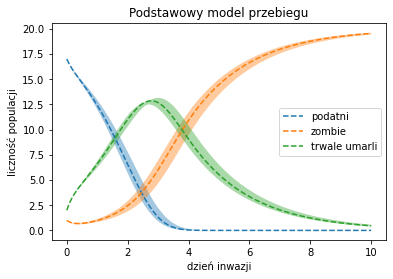

In [26]:
model_1(0.6, 0.4, 0.5, 17, 1, 2)

### 2)
Jednkaże, jest także drugi możliwy scenariusz w tym modelu - zostanie on otrzymany, gdy początkowe populacje zombie oraz trwale umarłych nie są początkowo różne od 0. Scenariusz ten odnosi się do sytuacji, w której nie zaistniała inwazja, więc populacje żadnej z grup nie ulegną zmianie (w szczególności populacje zombie i trwale umarłych będą nadal wynosić 0).

Sytuację tę można zapisać w poniższy sposób:
$$(\overline{S}, \overline{Z}, \overline{R}) = (\overline{S}, 0, 0).$$

Warto również zobaczyć jak wygląda ta 'alternatywna rzeczywistość':

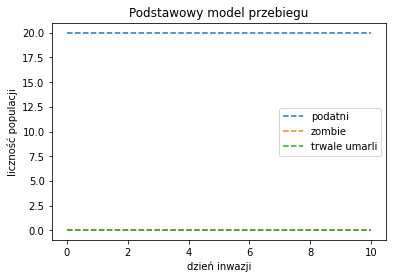

In [5]:
model_1(0.7, 0.4, 0.5, 20, 0, 0)

## Model 2 - model inwazji z pewnym okresem rozwoju zakażenia

Tym razem pojawia się jeszcze jedna grupa, którą należy wyróżnić:
*  I - populacja osób zainfekowanych

W związku z tym pojawiają się jeszcze 2 dodatkowe współczynniki:
* $\rho$ - tempo rozwoju zakażenia w organiźmie
* $i_0$ - liczność początkowa populacji osób zainfekowanych

Wykorzystując te, a także wprowadzone wcześniej grupy oraz współczynniki model inwazji z pewnym okresem rozwoju zakażenia można opisać następującym układem równań:

$$ S'(t) = -\beta S(t) Z(t), \qquad S(0) = s_0,$$
$$ I'(t) = \beta S(t) Z(t) - \rho I(t), \quad I(0) = i_0 $$
$$ Z'(t) = \rho I(t) + \zeta R(t) - \alpha S(t) Z(t) , \qquad Z(0) = z_0.$$
$$ R'(t) = \alpha S(t) Z(t) - \zeta R(t), \qquad R(0) = r_0.$$

Funkcja `model_2` zostaje określona w sposób podobny od `model_1`:

In [37]:
def model_2(a, b, c, p, s0, i0, z0, r0):
    def model_fun2(t, x, a, b, c, p):
        """
        Prawa strona modelu z pewnym okresem rozwoju zakażenia
        """
        S, I, Z, R = x
        f0 = - b * S * Z
        f1 = b * S * Z - p * I
        f2 = p * I + c * R - a * S * Z
        f3 = a * S * Z - c * R
        return [f0, f1, f2, f3]

    SIZR0 = [s0, i0, z0, r0]
    t = np.linspace(0, 10, 1000)
    
    distribution = cp.J(cp.Uniform(a*0.95, a*1.05),
                        cp.Uniform(b*0.95, b*1.05),
                        cp.Uniform(c*0.95, c*1.05),
                        cp.Uniform(p*0.95, p*1.05))
    samples = distribution.sample(10, "H")
    ode_sols = []
    for i in zip(*samples):
        ode_sols.append(integrate.solve_ivp(model_fun2, [0, 150], SIZR0, args=i, dense_output=True, method="RK45"))
    
    evals = [ode_sol.sol(t).T for ode_sol in ode_sols]

    ode_sol_coef = integrate.solve_ivp(model_fun2, [0, 150], SIZR0, args=(a, b, c, p), dense_output=True, method="RK45")
    plt.plot(t, ode_sol_coef.sol(t).T, '--')
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,0], (np.mean(evals, 0) + np.std(evals, 0))[:,0], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,1], (np.mean(evals, 0) + np.std(evals, 0))[:,1], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,2], (np.mean(evals, 0) + np.std(evals, 0))[:,2], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,3], (np.mean(evals, 0) + np.std(evals, 0))[:,3], alpha=.4)
        
    
    plt.xlabel("dzień inwazji")
    plt.ylabel("liczność populacji")
    plt.legend(["podatni", "zainfekowani", "zombie", "trwale umarli"])
    plt.title("Model inwazji z pewnym okresem rozwoju zakażenia")
    plt.show()

In [58]:
interact(model_2,
         a = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "alpha",
                                style = {'description_width': 'initial'}),
         b = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "beta",
                                style = {'description_width': 'initial'}),
         c = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "zeta",
                                style = {'description_width': 'initial'}),
         p = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "rho",
                                style = {'description_width': 'initial'}),
         s0 = widgets.IntSlider(min=0, max=100, step=1, value=80,
                                description = "podatni (t=0)",
                                style = {'description_width': 'initial'}),
         i0 = widgets.IntSlider(min=10, max=100, step=1, value=5,
                                description = "zainfekowani (t=0)",
                                style = {'description_width': 'initial'}),
         z0 = widgets.IntSlider(min=0, max=100, step=1, value=5,
                                description = "zombie (t=0)",
                                style = {'description_width': 'initial'}),
         r0 = widgets.IntSlider(min=0, max=100, step=1, value=20,
                                description = "trwale umarli (t=0)",
                                style = {'description_width': 'initial'}));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, min=0.1, style=SliderStyle(descript…

### Punkty krytyczne

Właśnie zaprezentowany model jest w rzeczywistości dość bilsko związany z pierwszym modelem, w związku z tym jego zachowanie wraz z upływem czasu jest podobne. Znowu możliwe do otrzymania są 2 scenariusze (z tym samym założeniem o współczynnikach).

### 1)
Jeśli przynajmniej jedna z początkowych populacji zombie, trwale umarłych lub zainfekowanych jest różna od 0, to po pewnym czasie (zależnym od doboru współczynników) zostaną jedynie zombie: $$\lim_{t\to\infty} Z(t) = z_0 + r_0 + s_0 + i_0.$$

Wykres wygląda wówczas następująco:

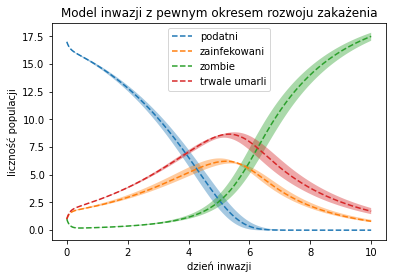

In [39]:
model_2(0.6, 0.5, 0.4, 0.5, 17, 1, 1, 1)

### 2)
W przeciwnym przypadku ponownie występuje scenariusz, w którym inwazja nie miała miejsca, a populacje wraz z upływem czasu będą równe odpowiednim populacjom początkowym.

Otrzymany w tej sytuacji wykres będzie bardzo podobny do braku inwazji w pierwszym modelu:

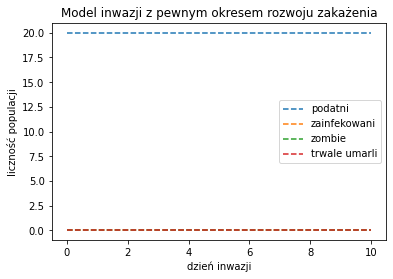

In [40]:
model_2(0.6, 0.5, 0.4, 0.5, 20, 0, 0, 0)

## Model 3 - model inwazji z kwarantanną

Model inwazji z kwarantanną wprowadza sporą odmianę w stosunku do `modelu_1` oraz `modelu_2`. Tym razem wprowadzony został pewien spsób przeciwdziałania inwazji, konkretnie poprzez umieszczanie w kwarantannie. Aby pomóc dobrze opisać ten model należy wprowadzić dodatkową grupę:
* Q - populacja jednostek będących w izolacji.

Pojawiają się także 3 nowe współczynniki:
* $\kappa$ - stała określająca odsetek populacji zainfekowanych trafiających do kwarantanny
* $\gamma$ - stała określająca odsetek populacji osób na kwarantannie, które nieudolnie próbując wydostać się na wolność, trafiają do populacji prawdziwie zmarłych
* $\delta$ - stała określająca odsetek populacji zombie trafiających do kwarantanny.

Wreszcie można otrzymać poniższy układ równań:

$$ S'(t) = -\beta S(t) Z(t), \qquad S(0) = s_0,$$
$$ I'(t) = \beta S(t) Z(t) - \rho I(t) - \kappa I(t), \quad I(0) = i_0,$$
$$ Z'(t) = \rho I(t) + \zeta R(t) - \alpha S(t) Z(t) - \delta Z(t), \qquad Z(0) = z_0,$$
$$ R'(t) = \alpha S(t) Z(t) - \zeta R(t) + \gamma Q(t), \qquad R(0) = r_0,$$
$$ Q'(t) = \kappa I(t) + \delta Z(t) - \gamma Q(t), \qquad Q(0) = q_0.$$

Sam sposób implementacji modelu nie odbiega od poprzednich przypadków:

In [43]:
def model_3(a, b, c, p, k, y, u, s0, i0, z0, r0, q0):
    def model_fun3(t, x, a, b, c, p, k, y, u):
        """
        Prawa strona modelu inwazji z kwarantanną
        """
        S, I, Z, R, Q = x
        f0 = - b * S * Z
        f1 = b * S * Z - (p + k) * I
        f2 = p * I + c * R - a * S * Z - u * Z
        f3 = a * S * Z - c * R + y * Q
        f4 = k * I + u * Z - y * Q
        return [f0, f1, f2, f3, f4]

    SIZRQ0 = [s0, i0, z0, r0, q0]
    t = np.linspace(0, 10, 1000)
    
    distribution = cp.J(cp.Uniform(a*0.95, a*1.05),
                        cp.Uniform(b*0.95, b*1.05),
                        cp.Uniform(c*0.95, c*1.05),
                        cp.Uniform(p*0.95, p*1.05),
                        cp.Uniform(k*0.95, k*1.05),
                        cp.Uniform(y*0.95, y*1.05),
                        cp.Uniform(u*0.95, u*1.05))
    samples = distribution.sample(5, "H")
    ode_sols = []
    for i in zip(*samples):
        ode_sols.append(integrate.solve_ivp(model_fun3, [0, 150], SIZRQ0, args=i, dense_output=True, method="RK45"))
    
    evals = [ode_sol.sol(t).T for ode_sol in ode_sols]
    
    ode_sol_coef = integrate.solve_ivp(model_fun3, [0, 150], SIZRQ0, args=(a, b, c, p, k, y, u), dense_output=True, method="RK45")
    plt.plot(t, ode_sol_coef.sol(t).T, '--')

    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,0], (np.mean(evals, 0) + np.std(evals, 0))[:,0], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,1], (np.mean(evals, 0) + np.std(evals, 0))[:,1], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,2], (np.mean(evals, 0) + np.std(evals, 0))[:,2], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,3], (np.mean(evals, 0) + np.std(evals, 0))[:,3], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,4], (np.mean(evals, 0) + np.std(evals, 0))[:,4], alpha=.4)
    
    
    plt.xlabel("dzień inwazji")
    plt.ylabel("liczność populacji")
    plt.legend(["podatni", "zainfekowani", "zombie", "trwale umarli", "izolowani"])
    plt.title("Model inwazji z kwarantanną")
    plt.show()

In [59]:
interact(model_3,
         a = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "alpha",
                                style = {'description_width': 'initial'}),
         b = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "beta",
                                style = {'description_width': 'initial'}),
         c = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "zeta",
                                style = {'description_width': 'initial'}),
         p = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "ro",
                                style = {'description_width': 'initial'}),
         k = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "kappa",
                                style = {'description_width': 'initial'}),
         y = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "gamma",
                                style = {'description_width': 'initial'}),
         u = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "delta",
                                style = {'description_width': 'initial'}),
         s0 = widgets.IntSlider(min=0, max=100, step=1, value=80,
                                description = "podatni (t=0)",
                                style = {'description_width': 'initial'}),
         i0 = widgets.IntSlider(min=0, max=100, step=1, value=5,
                                description = "zainfekowani (t=0)",
                                style = {'description_width': 'initial'}),
         z0 = widgets.IntSlider(min=0, max=100, step=1, value=5,
                                description = "zombie (t=0)",
                                style = {'description_width': 'initial'}),
         r0 = widgets.IntSlider(min=0, max=100, step=1, value=20,
                                description = "trwale umarli (t=0)",
                                style = {'description_width': 'initial'}),
         q0 = widgets.IntSlider(min=0, max=100, step=1, value=20,
                                description = "izolowani (t=0)",
                                style = {'description_width': 'initial'}));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, min=0.1, style=SliderStyle(descript…

## Punkty krytyczne

Powyższy model jest już ciekawszym opisem przebiegu inwazji zombie, ponieważ poza sytuacją, którą można nazwać 'bezinwazyjną' występuje też drugi scenariusz, w którym pozostaną ostatecznie przedstawiciele więcej niż tylko jednej grupy.

### 1)
W sytuacji, gdy przynajmniej jedna z grup poza populacją podatnych liczy więcej niż 0 osób otrzymane zostanie rozwiązanie, w którym po pewnym czasie pozostaną przedstawiciele aż 3 grup:
* izolowani
* zombie
* trwale umarli.

Warto również zaznaczyć, że: $$\lim_{t\to\infty} S(t) = I(t) = 0.$$


To rozwiązanie można zapisać następująco:
$$(\overline{S}, \overline{I}, \overline{Z}, \overline{R}, \overline{Q}) = (0, 0, \frac{\frac{\zeta}{\delta}(s_0 + i_o + z_0 + r_0 + q_0)}{(1 + \frac{\zeta}{\delta} + \frac{\zeta}{\gamma})}, \frac{(s_0 + i_o + z_0 + r_0 + q_0)}{(1 + \frac{\zeta}{\delta} + \frac{\zeta}{\gamma})}, \frac{\frac{\zeta}{\gamma}(s_0 + i_o + z_0 + r_0 + q_0)}{(1 + \frac{\zeta}{\delta} + \frac{\zeta}{\gamma})}).$$

Widać więc, że za ostateczne zależności pomiędzy populacjami, które przyjmować będą niezerowe wartości określają współczynniki $\zeta, \delta$ oraz $\gamma$.


Poniżej zaprezentowany jest przykładowy scenariusz opisujący tę sytuację:

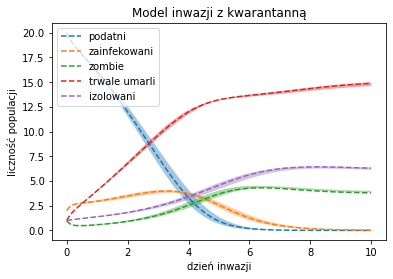

In [45]:
model_3(0.3, 0.4, 0.2, 0.9, 0.2, 0.5, 0.8, 20, 2, 1, 1, 1)

### 2)
Drugi scenariusz pokrywa się z tym, co zostało powiedziane przy modealch 1 i 2, a więc odnosi się do sytuacji, gdy na początku rozważanego okresu jedynie populacja osób podatnych mogła wynosić więcej niż 1.

Wówczas rozważany model wygląda następująco:

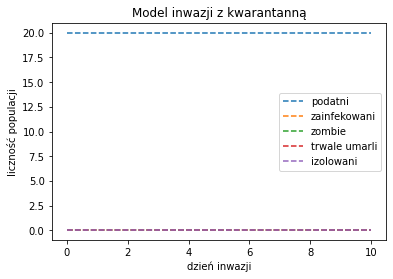

In [47]:
model_3(0.3, 0.4, 0.2, 0.9, 0.2, 0.5, 0.8, 20, 0, 0, 0, 0)

## Model 4 - model inwazji z wynalezionym leczeniem

Model inwazji z wynalezionym leczeniem to kolejny model, który uwzględnia przedsięwziecie środków mających na celu zwalczanie inwazji - tym razem jest to leczenie osobników zombie, a więc przywracanie ich do populacji podatnych (leczenie nie uodparnia na przyszłość). Tym razem nie jest potrzebna żadna nowa grupa, a jedynie jeden współczynnik:
* $c$ - stała określająca odsetek populacji zombie przywróconych do życia przy pomocy lekarstwa.

Wówczas `model_4` może zostać zapisany za pomocą poniższego układu równań:

$$ S'(t) = -\beta S(t) Z(t) + c Z(t), \qquad S(0) = s_0,$$
$$ I'(t) = \beta S(t) Z(t) - \rho I(t), \quad I(0) = i_0,$$
$$ Z'(t) = \rho I(t) + \zeta R(t) - \alpha S(t) Z(t) - c Z(t), \qquad Z(0) = z_0,$$
$$ R'(t) = \alpha S(t) Z(t) - \zeta R(t), \qquad R(0) = r_0.$$

Wizualizacja wykonywana jest znowu w podobny sposób:

In [49]:
def model_4(a, b, c, p, c2, s0, i0, z0, r0):
    def model_fun4(t, x, a, b, c, p, c2):
        """
        Prawa strona modelu inwazji z wynalezionym leczeniem
        """
        S, I, Z, R = x
        f0 = - b * S * Z + c2 * Z
        f1 = b * S * Z - p * I
        f2 = p * I + c * R - a * S * Z - c2 * Z
        f3 = a * S * Z - c * R
        return [f0, f1, f2, f3]

    SIZR0 = [s0, i0, z0, r0]
    t = np.linspace(0, 10, 1000)
    
    distribution = cp.J(cp.Uniform(a*0.95, a*1.05),
                        cp.Uniform(b*0.95, b*1.05),
                        cp.Uniform(c*0.95, c*1.05),
                        cp.Uniform(p*0.95, p*1.05),
                        cp.Uniform(c2*0.95, c2*1.05))
    samples = distribution.sample(5, "H")
    ode_sols = []
    for i in zip(*samples):
        ode_sols.append(integrate.solve_ivp(model_fun4, [0, 150], SIZR0, args=i, dense_output=True, method="RK45"))
    
    evals = [ode_sol.sol(t).T for ode_sol in ode_sols]
    
    ode_sol_coef = integrate.solve_ivp(model_fun4, [0, 150], SIZR0, args=(a, b, c, p, c2), dense_output=True, method="RK45")
    plt.plot(t, ode_sol_coef.sol(t).T, '--')
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,0], (np.mean(evals, 0) + np.std(evals, 0))[:,0], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,1], (np.mean(evals, 0) + np.std(evals, 0))[:,1], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,2], (np.mean(evals, 0) + np.std(evals, 0))[:,2], alpha=.4)
    plt.fill_between(t, (np.mean(evals, 0) - np.std(evals, 0))[:,3], (np.mean(evals, 0) + np.std(evals, 0))[:,3], alpha=.4)
    
    
    plt.xlabel("dzień inwazji")
    plt.ylabel("liczność populacji")
    plt.legend(["podatni", "zainfekowani", "zombie", "trwale umarli"])
    plt.title("Model inwazji z wynalezionym leczeniem")
    plt.show()

In [60]:
interact(model_4,
         a = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "alpha",
                                style = {'description_width': 'initial'}),
         b = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "beta",
                                style = {'description_width': 'initial'}),
         c = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "zeta",
                                style = {'description_width': 'initial'}),
         p = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "ro",
                                style = {'description_width': 'initial'}),
         c2 = widgets.FloatSlider(min = 0.1, max = 1, step = 0.1, value = 0.5,
                                description = "c",
                                style = {'description_width': 'initial'}),
         s0 = widgets.IntSlider(min=1, max=100, step=1, value=80,
                                description = "podatni (t=0)",
                                style = {'description_width': 'initial'}),
         i0 = widgets.IntSlider(min=1, max=100, step=1, value=5,
                                description = "zainfekowani (t=0)",
                                style = {'description_width': 'initial'}),
         z0 = widgets.IntSlider(min=1, max=100, step=1, value=5,
                                description = "zombie (t=0)",
                                style = {'description_width': 'initial'}),
         r0 = widgets.IntSlider(min=1, max=100, step=1, value=20,
                                description = "trwale umarli (t=0)",
                                style = {'description_width': 'initial'}));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, min=0.1, style=SliderStyle(descript…

## Punkty krytyczne

W tym przypadku również zachowanie jednego z rozwiązań jest głównie warte uwagi, poniważ drugie ponownie opisuje przypadek 'bezinwazyjny'.
### 1)
Wynalezienie lekarstwa umożliwia koegzystencję populacji podatnych oraz populacji zombie, co wydawałoby się teoretycznie niemożliwe, po zapoznaniu się z różnymi utworami pop-kulturowymi. Jednakże ostateczna liczność poszczególnych populacji może zostać zaprezentowana w następujący sposób:
$$(\overline{S}, \overline{I}, \overline{Z}, \overline{R}) = (\frac{c}{\beta}, w_0\frac{\frac{c}{\rho}}{\frac{c}{\rho} + 1 + \frac{\alpha c}{\rho \beta}}, \frac{w_0}{\frac{c}{\rho} + 1 + \frac{\alpha c}{\rho \beta}}, w_0\frac{\frac{\alpha c}{\rho \beta}}{\frac{c}{\rho} + 1 + \frac{\alpha c}{\rho \beta}}).$$
gdzie:
$w_0 = s_0 + i_0 + z_0 + r_0 - \frac{c}{\beta}$


W tej sytuacji niezwykle ciekawy jest aspekt populacji podatnych. Jej ostateczna wartość zależy jedynie od współczynników $c$ oraz $\beta$. Poniżej zaprezentowana jest taka sytuacja:

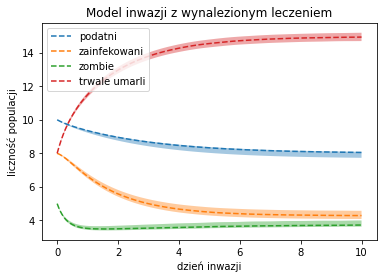

In [51]:
model_4(0.2, 0.1, 0.4, 0.7, 0.8, 10, 8, 5, 8)

Na powyższym wykresie iloraz $\frac{c}{\beta} = 8$ i rzeczywiście populacja podatnych dąży do wartości 8.

### 2)
Warto poświęcić też chwilę uwagi, pojawiającemu się przy okazji każdego modelu, scenariuszowi, w którym wszystkie populacje poza ewentualnie podatnymi wynoszą początkowo 0.

Opisać ten scenariusz można w poniższy sposób:
$$(\overline{S}, \overline{I}, \overline{Z}, \overline{R}) = (s_0, 0, 0, 0).$$

W tej sytuacji model inwazji z wynalezionym leczeniem przedstawia się następująco:

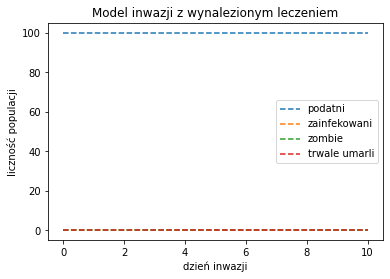

In [53]:
model_4(0.6, 0.5, 0.4, 0.5, 0.3, 100, 0, 0, 0)

Warto zastanowić się jeszcze nad sytuacją, gdy iloraz $\frac{c}{\beta}$ zwraca wartość wyższą niż suma wszystkich populacji na początku rozważanego okresu. Okazuje się, że wówczas ostateczna liczność poszczególnych populacji może być zaprezentowana następująco: $$(\overline{S}, \overline{I}, \overline{Z}, \overline{R}) = (s_0 + i_0 + z_0 + r_0, 0, 0, 0).$$

Wizualizacja takiej sytuacji może wyglądać jak poniżej:

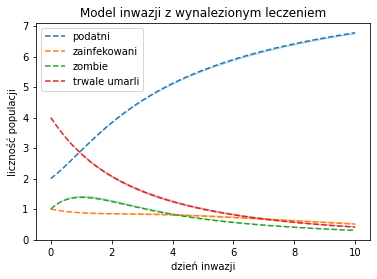

In [54]:
model_4(0.05, 0.05, 0.4, 0.3, 0.85, 2, 1, 1, 4)

Powyższy wykres to prawdopodobnie najciekawszy fragment tego raportu, ponieważ pokazuje on, że przy odpowiednich uwarunkowaniach za jakie należy uznać skuteczność lekarstwa oraz zaraźliwość wirusa możliwe jest zduszenie inwazji zombie.

## Podsumowanie

Rozważane modele sugerują, że inwazja zombie w przypadku nie podjęcia przez ludzkość żadnych działań bardzo szybko będzie się rozprzestrzeniać. Warto zauważyć, że nie ma na to wpływu fakt czy wirus rozwija się natychmiast, czy też potrzebuje trochę czasu, przekształcając osobę podatną w zainfekowaną, a dopiero później w zombie. Sytuacja zmienia się wraz z podjęciem przez ludzkość środków ochronnych. Sama kwarantanna może nie rozwiązywać w pełni problemu, jednak daje pewną możliwość koegzystencji zombie oraz innych grup, natomiast wynalezione leczenie daje ludzkości szansę nawet na całkowite pozbycie się populacji zombie.
Są to pocieszające informacje zważając na fakt, że chociaż inwazja zombie jest scenariuszem mało prawdopodobnym to powyższe modele mogą budować pewną intuicję odnośnie przebiegu epidemii innych chorób (oczywiście nie wystąpią w rzeczywistości przejścia 'powrotne' z grupy osób trwale umarłych). Warto także zanotować, że model z kwarantanną wydaje się być optymalny do oczekiwania na wynalezienie lekarstwa i pozwala zyskać naukowcom na czasie. Po odkryciu odpowiedniego lekarstwa wdrożony zostałby zapewne model zawierający zarówno kwarantannę, jak i leczenie, który nie został zbadany w powyższej pracy, a również może stanowić interesujący dodatek do niej. Oprócz tego rozważyć można model, w którym osoby wyzdrowiałe zyskują odporność na obecnego w społeczeństwie wirusa. Jak widać badanie modeli epidemiologicznych jest bardzo ciekawe niezależnie czy analizowana jest inwazja żywych trupów czy też bardziej realnego wirusa.

Na zakończenie warto dodać, że może jeszcze w najbliższym roku możliwa jest premiera drugiej części filmu `World War Z`, z którego ujęcie otwierało ten raport:

![](WWZ2-image.jpg)